In [2]:
from sympy import *
from IPython.display import display
init_printing()

# Three-body polynomial Jastrow

Three body Jastrow factor from "Jastrow correlation factor for atoms, molecules, and solids" N.D.Drummond, M.D.Towler, R.J.Needs, PRB 70 235119(2004)

See the 'gen_three_body.py' script for code generation

In [3]:
ri = Symbol('r_i')
rj = Symbol('r_j')
rij = Symbol('r_ij')
(ri, rj, rij)

In [44]:
C = Symbol('C')  # C is 2 or 3
L = Symbol('L')
gamma = IndexedBase('gamma')
r = IndexedBase('r')
l = Symbol('l',integer=True)
m = Symbol('m',integer=True)
n = Symbol('n',integer=True)
N = Symbol('N',integer=True)
N_ee = Symbol("N_ee",integer=True)
N_en = Symbol("N_en",integer=True)

In [45]:
# General form of the 3-body Jastrow
f = (ri - L)**C * (rj -L)**C * Sum(Sum(Sum(gamma[l,m,n]*ri**l *rj**m*rij**n,(l,0,N_en)),(n,0,N_en)),(m,0,N_ee))
f

                        Nₑₑ   Nₑₙ   Nₑₙ                               
                        ___   ___   ___                               
                        ╲     ╲     ╲                                 
         C           C   ╲     ╲     ╲     l     n    m               
(-L + rᵢ) ⋅(-L + r_j) ⋅  ╱     ╱     ╱   rᵢ ⋅r_ij ⋅r_j ⋅gamma[l, m, n]
                        ╱     ╱     ╱                                 
                        ‾‾‾   ‾‾‾   ‾‾‾                               
                       m = 0 n = 0 l = 0                              

In [6]:
# Concrete example for N_en = 1 and N_ee = 1
f1 = f.subs(N_en,1).subs(N_ee,1).doit()
f1

In [7]:
# Concrete example for N_en = 1 and N_ee = 2
f12 = f.subs(N_en,1).subs(N_ee,2).doit()
f12

## Constraints

$l$ is index for electron_1 - nuclei distance variable

$m$ is index for electron_2 - nuclei distance variable

$n$ is index for electron_1 - electron_2 distance variable

The Jastrow factor should be symmetric under electron exchange (swap $l$ and $m$) 


In [124]:
# How do we use this to simplify the expressions above?
Eq(gamma[l,m,n], gamma[m,l,n])

# Brute force - loop over m and l<m and create the substitutions (next cell)

In [125]:
# Concrete values of N_ee and N_en for all the following
NN_ee = 2
NN_en = 2
ftmp = f1
sym_subs = {}
display(ftmp)
for i1 in range(NN_en+1):
    for i2 in range(i1):
        for i3 in range(NN_ee+1):
            print(i1,i2,i3)
            display (gamma[i2,i1,i3], gamma[i1,i2,i3])
            #ftmp = ftmp.subs(gamma[i2,i1,i3], gamma[i1,i2,i3])
            sym_subs[gamma[i2,i1,i3]] = gamma[i1,i2,i3]
ftmp = f.subs(N_en,NN_en).subs(N_ee,NN_ee).doit().subs(sym_subs)
sym_subs

1 0 0


1 0 1


1 0 2


2 0 0


2 0 1


2 0 2


2 1 0


2 1 1


2 1 2


In [126]:
# Three body Jastrow with symmetry constraints
ftmp_sym = simplify(expand(ftmp))
ftmp_sym

In [127]:
# Find the free gamma values
{a for a in ftmp_sym.free_symbols if type(a) is Indexed}

### No electron-electron cusp

In [128]:
# First derivative of electron-electron distance should be zero at r_ij = 0
ftmp_ee = diff(ftmp, rij).subs(rij,0).subs(rj,ri)
ftmp_ee

In [129]:
# Remove the (r_i-L)**C part
ftmp2_ee = simplify(expand(ftmp_ee)).args[1]
ftmp2_ee

In [130]:
# Collect powers of r_i
ft3 = collect(ftmp2_ee,ri)
ft3

In [131]:
# Convert to polynomial to extract coefficients of r_i
pt3 = poly(ft3,ri)
pt3

In [132]:
pt4 = pt3.all_coeffs()
pt4

In [133]:
# To enforce results are zero for all distance, the coefficients must be zero
ee_soln = solve(pt4)
ee_soln

### No electron-nuclei cusp

In [134]:
# First derivative of electron-nuclei distance should be zero at r_i = 0
ftmp_en = diff(ftmp, ri).subs(ri,0).subs(rij,rj)
ftmp_en

In [135]:
simplify(expand(ftmp_en))

In [136]:
# Remove the (-L)**(C-1) * (r_j -L)**C part
simplify(expand(ftmp_en)).args[2]

In [137]:
# Put in constraints from e-e cusp
ftmp_en2 = ftmp_en.subs(ee_soln)
ftmp_en2

In [138]:
simplify(ftmp_en2)

In [143]:
ftmp_en3 = simplify(expand(ftmp_en2))
ftmp_en3

In [144]:
# Remove the (-L)**(C-1) * (r_j -L)**C part
ftmp_en3 = ftmp_en3.subs(sym_subs).args[2]
ftmp_en3

In [145]:
# Powers of r_j
collect(expand(ftmp_en3),rj)

In [146]:
# Convert to polynomial to extract coefficients
pe3 = poly(ftmp_en3,rj)
pe3

In [114]:
pe4 = pe3.all_coeffs()
print(len(pe4))
pe4

5


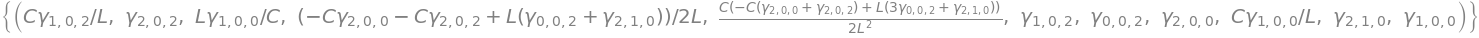

In [147]:
# Solve can be very slow as the expansion size increases
#en_soln = solve(pe4)
# Using linsolve is faster
soln_var = {a for a in ftmp_en3.free_symbols if type(a) is Indexed}
en_soln = linsolve(pe4, soln_var)

en_soln

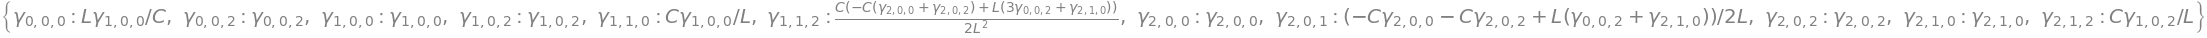

In [148]:
# Don't want the C=0,L=0 solution when using solve
#en_soln2 = en_soln[1]
#en_soln2
# If using linsolve
for tmp_soln in en_soln:
    en_soln2 = {g:v for g,v in zip(soln_var, tmp_soln)}
en_soln2

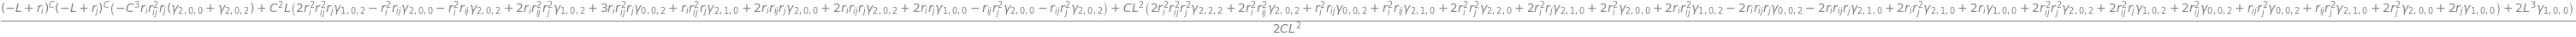

In [149]:
# Final expression with all the constraints inserted
ftmp_out = ftmp.subs(sym_subs).subs(ee_soln).subs(en_soln2)
ftmp_out2 = simplify(expand(ftmp_out))
ftmp_out2

In [150]:
# Find the free gamma values
{a for a in ftmp_out2.free_symbols if type(a) is Indexed}

## Formula from Appendix of the paper

In [123]:
NN_en = 2
NN_ee = 2
Nc_en = 2*NN_en + 1
Nc_ee = NN_en + NN_ee + 1
N_gamma = (NN_en + 1)*(NN_en+2)//2 * (NN_ee + 1)
print('Number of gamma values (after symmetry) : ',N_gamma)
print('Number of e-e constraints : ',Nc_ee)
print('Number of e-n constraints : ',Nc_en)
print('Number of free param = ',N_gamma - Nc_ee - Nc_en)

# Note, for N_en=1 and N_en=1, this formula doesn't match the above derivation. 
# For all higher values it does match.

Number of gamma values (after symmetry) :  18
Number of e-e constraints :  5
Number of e-n constraints :  5
Number of free param =  8


In [120]:
# For the electron-electron cusp
for k in range(0,2*NN_en+1):
    terms = 0
    print(k)
    for l in range(0,NN_en+1):
        for m in range(0,l):
            if l+m == k:
                #print(' ',l,m,'2*gamma[%d,%d,1]'%(l,m))
                terms += 2*gamma[l,m,1]
    # sum over l,m such that l+m == k and l>m
    # plus
    # sum over l such that 2l == k
    for l in range(0,NN_en):
        if 2*l == k:
            #print(' ',l,'gamma[%d,%d,1]'%(l,l))
            terms += 2*gamma[l,l,1]
    print('k: ',k,' terms: ',terms)

0
k:  0  terms:  2*gamma[0, 0, 1]
1
k:  1  terms:  2*gamma[1, 0, 1]
2
k:  2  terms:  2*gamma[1, 1, 1] + 2*gamma[2, 0, 1]
3
k:  3  terms:  2*gamma[2, 1, 1]
4
k:  4  terms:  0


In [121]:
# For the electron-nuclear cusp
for kp in range(0,NN_en + NN_ee+1):
    terms = 0
    if kp <= NN_ee:
        terms = C*gamma[0,0,kp] - L*gamma[1,0,kp]
    # sum of l,n such that l + n == kp and l>=1
    for l in range(1,NN_en+1):
        for n in range(NN_ee+1):
            if l + n == kp:
                terms += C*gamma[l,0,n] - L*gamma[l,1,n]
    print('kp: ',kp,' terms: ',terms)
            
    

kp:  0  terms:  C*gamma[0, 0, 0] - L*gamma[1, 0, 0]
kp:  1  terms:  C*gamma[0, 0, 1] + C*gamma[1, 0, 0] - L*gamma[1, 0, 1] - L*gamma[1, 1, 0]
kp:  2  terms:  C*gamma[0, 0, 2] + C*gamma[1, 0, 1] + C*gamma[2, 0, 0] - L*gamma[1, 0, 2] - L*gamma[1, 1, 1] - L*gamma[2, 1, 0]
kp:  3  terms:  C*gamma[1, 0, 2] + C*gamma[2, 0, 1] - L*gamma[1, 1, 2] - L*gamma[2, 1, 1]
kp:  4  terms:  C*gamma[2, 0, 2] - L*gamma[2, 1, 2]
